In [ ]:
# Google Drive'a bağlan
from google.colab import drive
drive.mount('/content/drive')

# Gerekli temel kütüphaneler
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetV2L

# Elle tanımlanmış focal loss fonksiyonu
import tensorflow.keras.backend as K
def categorical_focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.sum(loss, axis=1)
    return loss

print("✅ Google Drive bağlı, focal loss ve kütüphaneler hazır.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive bağlı, focal loss ve kütüphaneler hazır.


In [ ]:
data_dir = "/content/drive/MyDrive/dataset"
filepaths, labels = [], []
for label in os.listdir(data_dir):
    for file in os.listdir(os.path.join(data_dir, label)):
        filepaths.append(os.path.join(data_dir, label, file))
        labels.append(label)

df = pd.DataFrame({"filepath": filepaths, "labels": labels})
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df.labels, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df.labels, random_state=42)

print(f"Train: {len(train_df)}, Valid: {len(valid_df)}, Test: {len(test_df)}")


Train: 2951, Valid: 633, Test: 633


In [ ]:
import cv2

def preprocess_image(path, target_size=(224, 224)):
    img = cv2.imread(path)
    img = cv2.resize(img, target_size)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    img = cv2.bilateralFilter(img, 9, 75, 75)
    img = img.astype("float32") / 255.0
    return img


In [ ]:
from tensorflow.keras.utils import Sequence

class CustomDataGenerator(Sequence):
    def __init__(self, df, class_indices, batch_size=32, is_train=True, augment_fn=None):
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.class_indices = class_indices
        self.is_train = is_train
        self.augment_fn = augment_fn
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        self.indices = np.arange(len(self.df))
        if self.is_train:
            np.random.shuffle(self.indices)

    def __getitem__(self, idx):
        batch_indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indices]
        X, y = [], []
        for _, row in batch_df.iterrows():
            img = preprocess_image(row['filepath'])
            if self.augment_fn and self.is_train:
                img = self.augment_fn(img)
            label = self.class_indices[row['labels']]
            label_one_hot = tf.keras.utils.to_categorical(label, num_classes=len(self.class_indices))
            X.append(img)
            y.append(label_one_hot)
        return np.array(X), np.array(y)


In [ ]:
class_names = sorted(df.labels.unique())
class_indices = {name: idx for idx, name in enumerate(class_names)}
y_train_labels = train_df.labels.map(class_indices)
class_weights_array = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weights = dict(enumerate(class_weights_array))
print("✅ Class weights hazır.")

✅ Class weights hazır.


In [ ]:
def create_model():
    try:
        from tensorflow.keras.applications import EfficientNetB0
        base = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
        x = base.output
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.4)(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dropout(0.3)(x)
        out = layers.Dense(len(class_indices), activation='softmax')(x)
        model = models.Model(inputs=base.input, outputs=out)
        model.compile(optimizer=Adam(1e-4), loss=categorical_focal_loss(gamma=2.0, alpha=0.25), metrics=['accuracy'])
        return model
    except Exception as e:
        print(f"Model oluşturulurken hata oluştu: {e}")
        return None

In [ ]:
models_list = [create_model() for _ in range(3)]

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2, verbose=1)


In [ ]:
train_gen = CustomDataGenerator(train_df, class_indices)
val_gen = CustomDataGenerator(valid_df, class_indices, is_train=False)

for i, m in enumerate(models_list):
    print(f"\n🔁 Model {i+1} eğitiliyor...")
    m.fit(train_gen, validation_data=val_gen, epochs=15, callbacks=[early_stop, lr_scheduler], class_weight=class_weights)



🔁 Model 1 eğitiliyor...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 2463s 26s/step - accuracy: 0.5106 - loss: 0.1516 - val_accuracy: 0.2464 - val_loss: 0.2689 - learning_rate: 1.0000e-04
Epoch 2/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 83s 890ms/step - accuracy: 0.8135 - loss: 0.0546 - val_accuracy: 0.2464 - val_loss: 0.3608 - learning_rate: 1.0000e-04
Epoch 3/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 748ms/step - accuracy: 0.8761 - loss: 0.0323
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
93/93 ━━━━━━━━━━━━━━━━━━━━ 84s 904ms/step - accuracy: 0.8761 - loss: 0.0323 - val_accuracy: 0.2464 - val_loss: 0.2824 - learning_rate: 1.0000e-04
Epoch 4/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 91s 976ms/step - accuracy: 0.9080 - loss: 0.0220 - val_accuracy: 0.4502 - val_loss: 0.2628 - learning_rate: 2.0000e-05
Epoch 5/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 84s 907ms/step - accuracy: 0.9171 - loss: 0.0215 - val_accuracy: 0.4676 - val_loss: 0.1742 - learning_rate: 2.0000e-05
Epoch 6/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 84s 901ms/step - accuracy

In [ ]:
test_gen = CustomDataGenerator(test_df, class_indices, is_train=False)
predictions = [m.predict(test_gen) for m in models_list]
final_preds = np.mean(predictions, axis=0)
final_labels = np.argmax(final_preds, axis=1)
true_labels = test_df.labels.map(class_indices).values

print("\n✅ Ensemble Classification Report")
print(classification_report(true_labels, final_labels, target_names=class_names))


20/20 ━━━━━━━━━━━━━━━━━━━━ 409s 21s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step

✅ Ensemble Classification Report
                      precision    recall  f1-score   support

            cataract       0.91      0.94      0.93       156
diabetic_retinopathy       1.00      0.99      0.99       165
            glaucoma       0.86      0.79      0.82       151
              normal       0.85      0.89      0.87       161

            accuracy                           0.91       633
           macro avg       0.90      0.90      0.90       633
        weighted avg       0.91      0.91      0.90       633



/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_10755']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


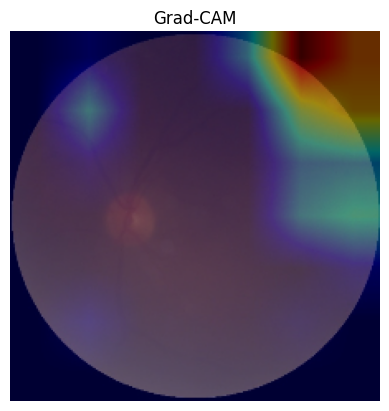

In [ ]:
from tensorflow.keras.models import Model

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

sample_path = test_df.sample(1).iloc[0]["filepath"]
img = tf.keras.preprocessing.image.load_img(sample_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

heatmap = make_gradcam_heatmap(img_array, models_list[0], last_conv_layer_name="top_conv")
import cv2
heatmap = cv2.resize(heatmap, (224, 224))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
original = cv2.imread(sample_path)
original = cv2.resize(original, (224, 224))
superimposed_img = cv2.addWeighted(original, 0.6, heatmap, 0.4, 0)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Grad-CAM")
plt.show()

In [ ]:
def tta_prediction(model, generator, tta_steps=5):
    tta_preds = []
    for _ in range(tta_steps):
        preds = model.predict(generator, verbose=0)
        tta_preds.append(preds)
    return np.mean(tta_preds, axis=0)

tta_preds = tta_prediction(models_list[0], test_gen, tta_steps=5)
tta_y_pred = np.argmax(tta_preds, axis=1)
print("\n✅ TTA Classification Report")
print(classification_report(true_labels, tta_y_pred, target_names=class_names))



✅ TTA Classification Report
                      precision    recall  f1-score   support

            cataract       0.91      0.94      0.92       156
diabetic_retinopathy       0.99      1.00      1.00       165
            glaucoma       0.82      0.82      0.82       151
              normal       0.89      0.86      0.87       161

            accuracy                           0.91       633
           macro avg       0.90      0.90      0.90       633
        weighted avg       0.90      0.91      0.90       633



In [ ]:
for i, model in enumerate(models_list):
    model.save(f"/content/drive/MyDrive/ensemble_model_{i+1}.keras")
print("✅ Tüm modeller başarıyla kaydedildi.")


✅ Tüm modeller başarıyla kaydedildi.


In [ ]:
import joblib
class_labels = {idx: name for idx, name in enumerate(class_names)}
# Kaydet
joblib.dump(class_labels, "/content/drive/MyDrive/ensemble_class_labels.pkl")

# Yüklemek için
# class_labels = joblib.load("/content/drive/MyDrive/ensemble_class_labels.pkl")


['/content/drive/MyDrive/ensemble_class_labels.pkl']

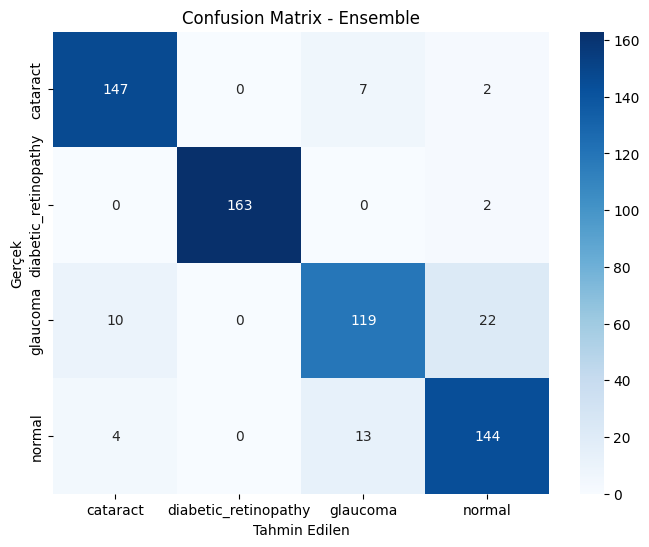

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Gerçek etiketler
true_labels = test_df.labels.map(class_indices).values

# Ensemble tahminler (zaten alınmış olmalı)
# Eğer yoksa şunu çalıştır:
# predictions = [m.predict(test_gen) for m in models_list]
# final_preds = np.mean(predictions, axis=0)
# final_labels = np.argmax(final_preds, axis=1)

# Confusion matrix
cm = confusion_matrix(true_labels, final_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title("Confusion Matrix - Ensemble")
plt.show()
